In [ ]:
!pip install transformers
# Installing the required libraries such as Optuna, Transformers, Datasets, and Torchmetrics, uncomment and run if needed
!pip install optuna transformers datasets torchmetrics -q
!pip install tensorflow
!pip install contractions
!pip install emoji

import emoji
import contractions

# PyTorch libraries
import torch
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader

# Tensorflow libraries
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import numpy as np
import re
from time import time
import seaborn as sns

import IPython
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, get_linear_schedule_with_warmup
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace

from torch.optim import AdamW
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support


from collections import Counter




%matplotlib inline


In [ ]:
# Using Google Drive to save model state in case colab ends runtime after study while not at PC
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/Emotion_Recognition_in_Text/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # Loading the GoEmotions dataset in its raw version for further EDA purposes
dataset_for_eda = load_dataset("go_emotions", "raw")


In [ ]:
dataset_for_eda.shape

{'train': (211225, 37)}

In [ ]:
df = dataset_for_eda['train'].to_pandas()
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Checking the missing values pecentage in Goemotions dataset
missing_sum = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_sum, missing_percent*100], axis=1, keys=['Sum', 'Percent'])
missing_data

,Sum,Percent
text,0,0.0
disapproval,0,0.0
embarrassment,0,0.0
excitement,0,0.0
fear,0,0.0
gratitude,0,0.0
grief,0,0.0
joy,0,0.0
love,0,0.0
nervousness,0,0.0


In [ ]:
# Importing necessary libraries
from wordcloud import WordCloud

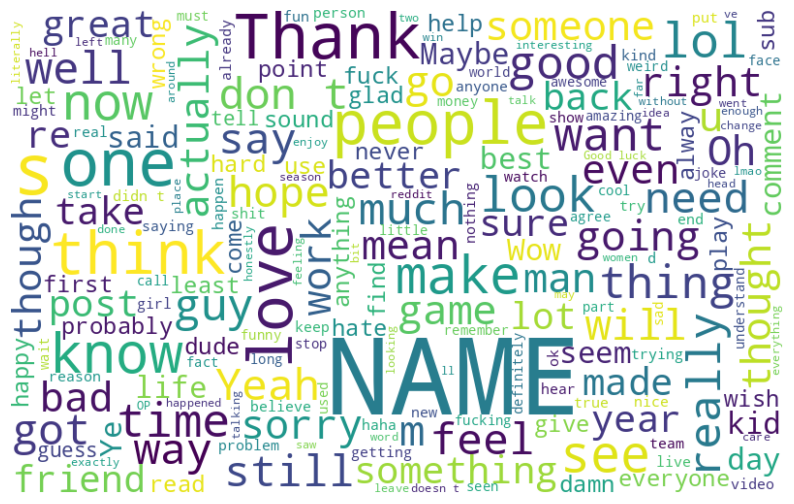

In [ ]:
# Combine all the text in your dataframe
all_text = ' '.join(text for text in df['text'])

# Generate the word cloud
wordcloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=110).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

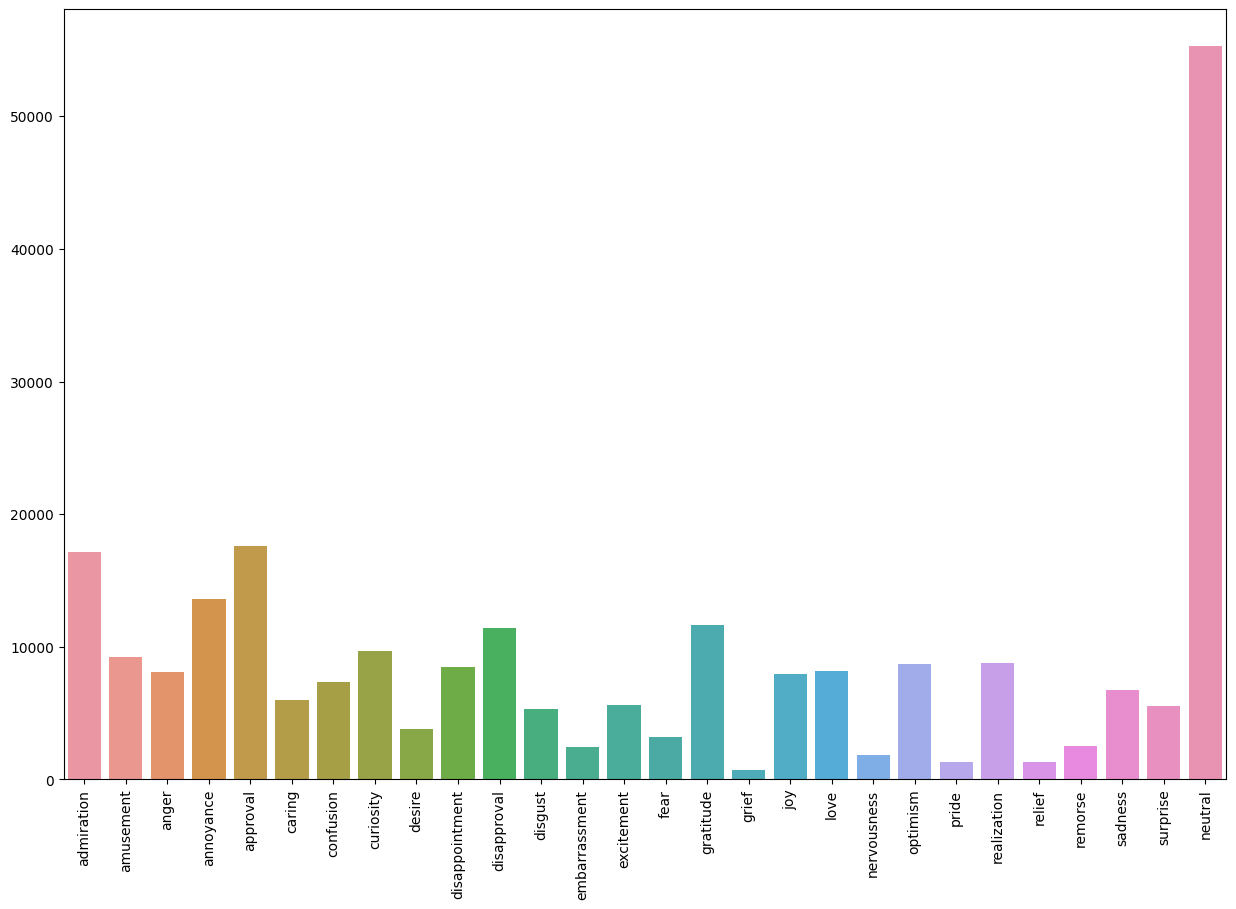

In [ ]:
# Count the instances of each label
label_counts = df.iloc[:, -28:].sum()

# Visualize the distribution of labels
plt.figure(figsize=(15,10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.show()

Mean text length:  12.99718783287963
Min text length:  1
Max text length:  33


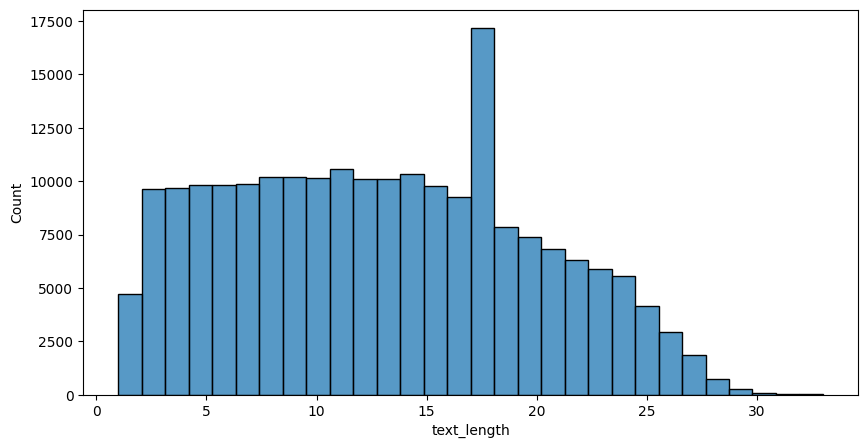

In [ ]:
# Create a new column in the dataframe for the length of the text
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Print the mean, min and max text length
print("Mean text length: ", df['text_length'].mean())
print("Min text length: ", df['text_length'].min())
print("Max text length: ", df['text_length'].max())

# Plot a histogram of the text length
plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], bins=30)
plt.show()

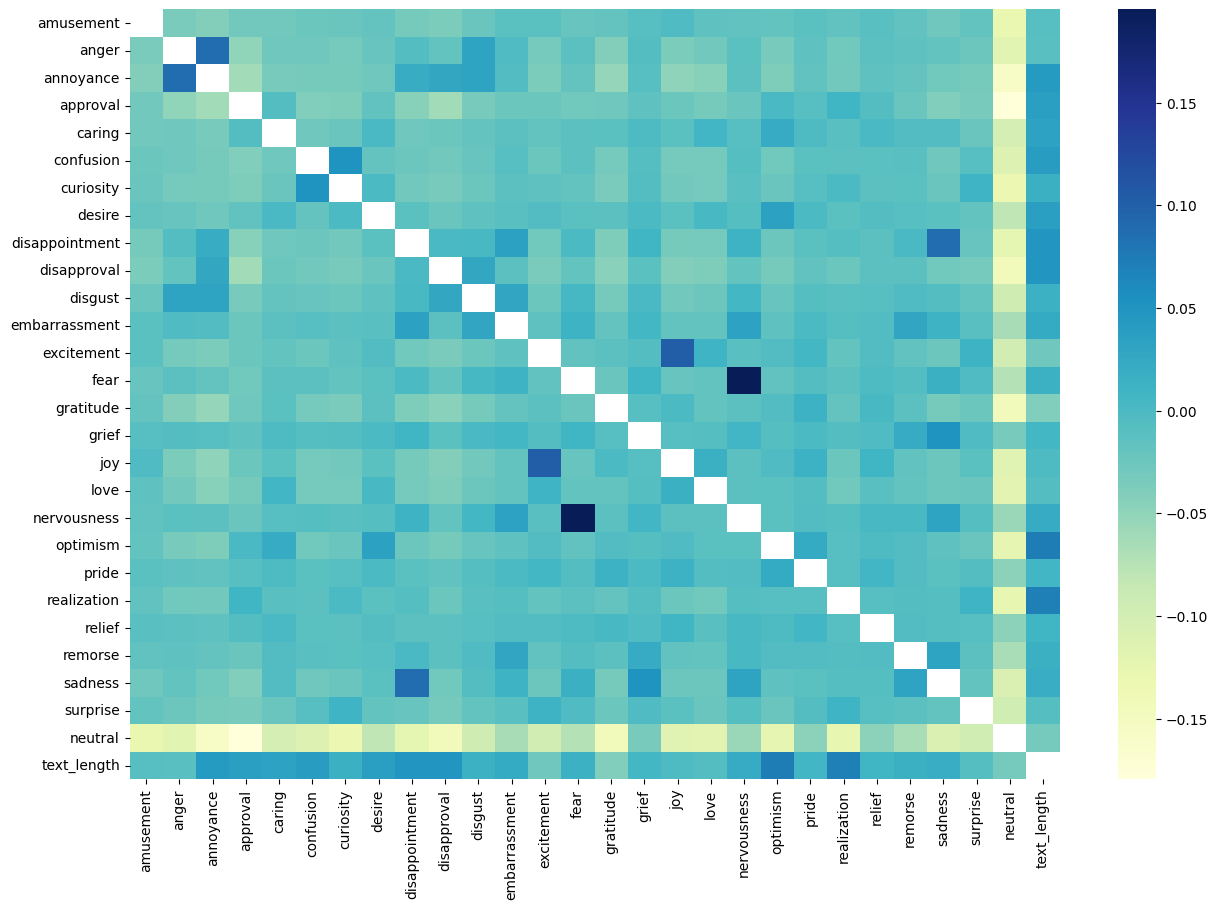

In [ ]:
import numpy as np

# Compute the correlation matrix
correlation_matrix = df.iloc[:, -28:].corr()

# Replace the diagonal values with NaN
np.fill_diagonal(correlation_matrix.values, np.nan)

# Create a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, cmap='YlGnBu')
plt.show()

In [ ]:
# Loading the GoEmotions dataset in its simplified version for further model architecture building
dataset = load_dataset("go_emotions", "simplified")


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [ ]:
dataset.shape

{'train': (43410, 3), 'validation': (5426, 3), 'test': (5427, 3)}

In [ ]:
# Initializing the Roberta tokenizer with base configuration.
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

In [ ]:
# add normalizers and pre_tokenizer to the tokenizer
tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()

In [ ]:
# Defining a function to process individual text in the dataset. This includes tokenization, padding, and truncation.
def tokenize_text(text):
    # Tokenize the text
    tokenized = tokenizer(text['text'], add_special_tokens=True, truncation=True, padding='max_length', max_length=50, return_tensors="pt")

    # Convert labels to a binary vector
    label_vector = torch.zeros(28)
    for label in text['labels']:
        label_vector[label] = 1

    processed_text = ""
    """Cleaning text using preprocesing activities."""
    processed_text = text["text"].lower().strip()
    processed_text = re.sub(r'\[[^\]]*\]', '', processed_text) # remove brackets
    processed_text = re.sub(r'[^\w\s]', '', processed_text) # remove panctuations
    pattern = re.compile(r'[0-9]+') # remove numbers
    processed_text = pattern.sub('', processed_text)
    processed_text = emoji.demojize(processed_text) # replace emoji with actual text
    processed_text = re.sub(r'[^\w\s]', '', processed_text) # removing special characters and emojis if any
    processed_text = contractions.fix(processed_text) # fix contractions

    return {
        'input_ids': tokenized['input_ids'].squeeze(),
        'attention_mask': tokenized['attention_mask'].squeeze(),
        'labels': label_vector,
        'text': processed_text,
    }

train_data = dataset['train'].map(tokenize_text)
test_data = dataset['test'].map(tokenize_text)

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
# Setting the format of the training and test data to torch tensors and specifying the required columns.
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
# Defining hyperparameters such as weight decay and learning rate for training the model.

args = {
    'weight_decay': 0.0,
    'learning_rate': 5e-5,
    'epochs': 10,
    'gradient_accumulation_steps':1,
    'epsilon': 1e-8,
    'warmup_proportion': 0.1,
    "train_batch_size": 16,
    "eval_batch_size": 32,
}

num_classes = 28

In [ ]:
train_params = {'batch_size': args['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': args['eval_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Creating a DataLoader for the training and test data, with shuffling and specified batch size.
train_loader = DataLoader(train_data, **train_params)
test_loader = DataLoader(test_data, **test_params)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.config = RobertaConfig.from_pretrained('roberta-base', num_labels=num_classes)
        self.pre_classifier = torch.nn.Linear(self.config.hidden_size, self.config.hidden_size)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass(num_classes)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
# Initializing the AdamW optimizer with the grouped parameters and specified learning rate.
optimizer = torch.optim.Adam(params =  model.parameters(), lr=args['learning_rate'], eps=args['epsilon'])

In [ ]:
# Defining the loss function as Binary Cross-Entropy with Logits Loss.
loss_function = BCEWithLogitsLoss()

In [ ]:
# Training loop
training_loss, training_accuracy = [], []
all_labels, all_preds = [], []

for epoch in range(args['epochs']):
    for _,data in tqdm(enumerate(train_loader, 0)):
        optimizer.zero_grad()

        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss    = loss_function(outputs, labels.float())

        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        loss.backward()
        optimizer.step()

    training_loss.append(loss)
    training_accuracy.append(accuracy_score(all_labels, all_preds))

2714it [06:50,  6.62it/s]
2714it [06:51,  6.60it/s]
2714it [06:51,  6.59it/s]
2714it [06:51,  6.59it/s]
2714it [06:51,  6.59it/s]
2714it [06:51,  6.59it/s]
2714it [06:51,  6.60it/s]
2714it [06:51,  6.59it/s]
2714it [06:51,  6.59it/s]
2714it [06:51,  6.60it/s]


In [ ]:
# After training, evaluate on the training set
model.eval()

all_labels, all_preds = [], []

with torch.no_grad():
    for _,data in tqdm(enumerate(train_loader, 0)):
        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        #_, preds = torch.max(outputs, 1)
        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate metrics
train_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {precision}')
print(f'Training Recall: {recall}')
print(f'Training F1 Score: {f1}')

2714it [02:02, 22.08it/s]


Training Accuracy: 0.9036857866850956
Training Precision: 0.9689018750640936
Training Recall: 0.8949676560878908
Training F1 Score: 0.9289074243314154


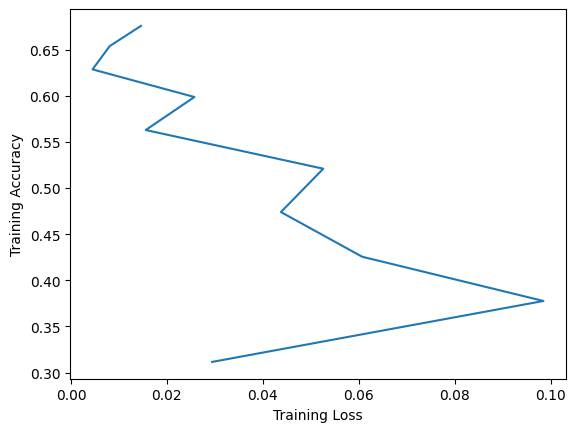

In [ ]:
# Plot the training accuracy curve
fi_los = [fl.item() for fl in training_loss ]

plt.plot(fi_los, training_accuracy)
plt.xlabel('Training Loss')
plt.ylabel('Training Accuracy')
plt.show()

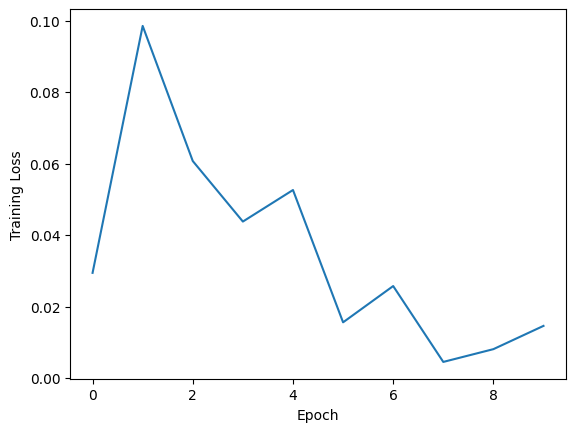

In [ ]:
plt.plot(range(args['epochs']), fi_los)
plt.ylabel('Training Loss')
plt.xlabel('Epoch');

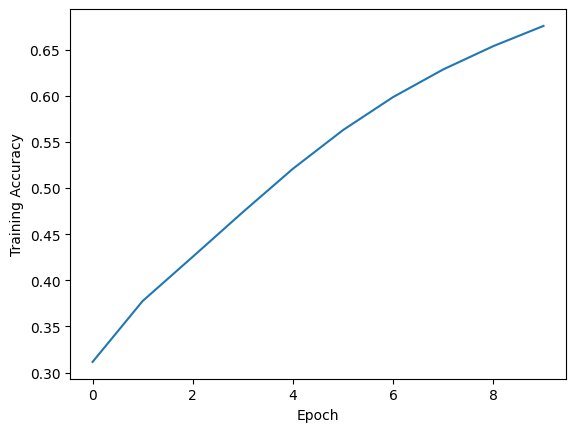

In [ ]:
plt.plot(range(args['epochs']), training_accuracy)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch');

In [ ]:
#evaluating on the goemotion test set

model.eval()
dict_test_results = {'actual':[], 'preds':[]}
all_labels_test, all_preds_test = [], []

with torch.no_grad():
    for _,data in tqdm(enumerate(test_loader, 0)):
        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        #_, preds = torch.max(outputs, 1)
        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels_test.extend(labels.cpu().numpy())
        all_preds_test.extend(preds.cpu().numpy())

        dict_test_results['actual'] += labels.cpu().numpy().tolist()
        dict_test_results['preds'] += preds.cpu().numpy().tolist()

# Calculate metrics
test_accuracy = accuracy_score(all_labels_test, all_preds_test)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels_test, all_preds_test, average='macro')

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Precision: {precision}')
print(f'Testing Recall: {recall}')
print(f'Testing F1 Score: {f1}')

170it [00:13, 12.74it/s]

Testing Accuracy: 0.4488667772249862
Testing Precision: 0.5196199662984055
Testing Recall: 0.4431149897609345
Testing F1 Score: 0.46492973421485295


In [ ]:
# Mapping the label IDs to their corresponding emotion names.
id2label = {0:"admiration",
            1:"amusement",
            2:"anger",
            3:"annoyance",
            4:"approval",
            5:"caring",
            6:"confusion",
            7:"curiosity",
            8:"desire",
            9:"disappointment",
            10:"disapproval",
            11:"disgust",
            12:"embarrassment",
            13:"excitement",
            14:"fear",
            15:"gratitude",
            16:"grief",
            17:"joy",
            18:"love",
            19:"nervousness",
            20:"optimism",
            21:"pride",
            22:"realization",
            23:"relief",
            24:"remorse",
            25:"sadness",
            26:"surprise",
            27:"neutral"}

In [ ]:
# Defining a function to calculate performance metrics such as accuracy, precision, recall, and F1-score.

def get_performance(actual_og, preds_og, dict_mapping):
    # Convert one-hot encoding to label encoding
    actual_ = [np.argmax(item) for item in actual_og]
    preds_ = [np.argmax(item) for item in preds_og]

    # Convert to label names
    target_names = [dict_mapping[i] for i in range(len(dict_mapping))]

    conf_matrix = confusion_matrix(actual_, preds_)

    # Displaying the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the classification report
    report = classification_report(actual_, preds_, target_names=target_names)

    print(report)

    print('Actual counter:', Counter(actual_))
    print('Prediction counter:', Counter(preds_))

    return report

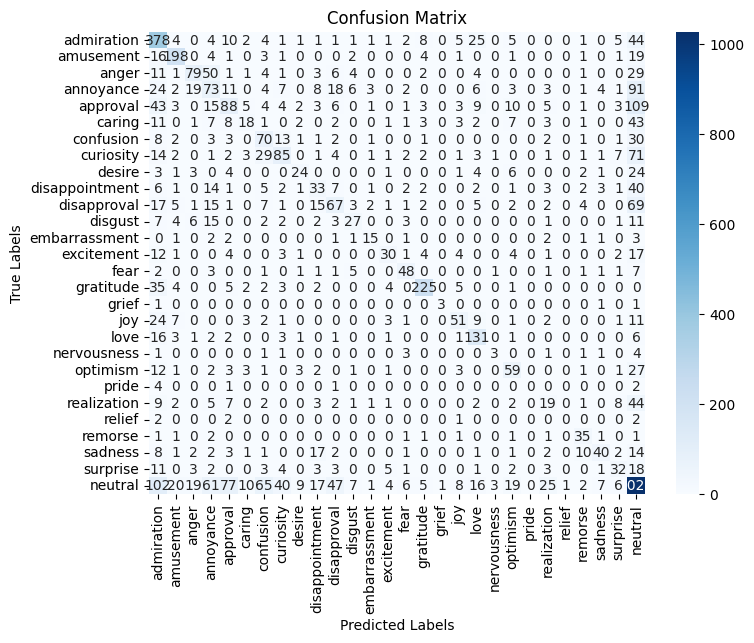

                precision    recall  f1-score   support

    admiration       0.49      0.75      0.59       504
     amusement       0.75      0.79      0.77       252
         anger       0.59      0.40      0.48       197
     annoyance       0.26      0.26      0.26       286
      approval       0.37      0.28      0.32       318
        caring       0.38      0.16      0.22       114
     confusion       0.33      0.50      0.40       139
     curiosity       0.49      0.36      0.42       233
        desire       0.52      0.32      0.40        74
disappointment       0.29      0.26      0.28       127
   disapproval       0.39      0.30      0.34       220
       disgust       0.47      0.32      0.38        84
 embarrassment       0.56      0.50      0.53        30
    excitement       0.56      0.36      0.43        84
          fear       0.62      0.65      0.64        74
     gratitude       0.86      0.78      0.82       288
         grief       0.75      0.50      0.60  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluating the trained model on the test data and reporting the results in a DataFrame.
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label)

In [ ]:
def convert_string_to_list(s):
    # Split the string by commas
    parts = s.split(',')

    # Convert each part to an integer
    try:
        result = [int(part) for part in parts]
    except ValueError:
        # Handle the case where conversion to int fails
        print("Conversion failed. Check your input.")
        return None

    return result

def get_test_loader_taxonomy(taxonomy):

    # Read the TSV file into a Pandas DataFrame
    if taxonomy == 'ekman':
      df = pd.read_csv(path+'ekman/test.tsv', sep='\t', names=['text', 'labels', 'id'])
    else:
      df = pd.read_csv(path+'group/test.tsv', sep='\t', names=['text', 'labels', 'id'])

    data_dict = {
        'text': df["text"].astype(str).tolist(),
        'labels': df['labels'].apply(convert_string_to_list).tolist(),
        'id': df['id'].astype(str).tolist(),
    }

    # Convert DataFrame to Hugging Face Dataset
    test_data_taxonomy = Dataset.from_dict(data_dict)

    test_data_taxonomy = test_data_taxonomy.map(tokenize_text)
    test_data_taxonomy.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    test_loader_taxonomy = DataLoader(test_data_taxonomy, **test_params)

    return test_loader_taxonomy

def get_labels(taxonomy):
            labels = []
            data_dir = path+'ekman/labels.txt'
            with open(data_dir , "r", encoding="utf-8") as f:
                for line in f:
                    labels.append(line.rstrip())
            return labels



In [ ]:
test_loader_ekman = get_test_loader_taxonomy('ekman')

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
#evaluating on the goemotion test set

model.eval()
dict_test_results_ekman = {'actual':[], 'preds':[]}
all_labels_test_ekman, all_preds_test_ekman = [], []

with torch.no_grad():
    for _,data in tqdm(enumerate(test_loader_ekman, 0)):
        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        #_, preds = torch.max(outputs, 1)
        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels_test_ekman.extend(labels.cpu().numpy())
        all_preds_test_ekman.extend(preds.cpu().numpy())

        dict_test_results_ekman['actual'] += labels.cpu().numpy().tolist()
        dict_test_results_ekman['preds'] += preds.cpu().numpy().tolist()

# Calculate metrics
test_accuracy_ekman = accuracy_score(all_labels_test, all_preds_test)
precision_ekman, recall_ekman, f1_ekman, _ = precision_recall_fscore_support(all_labels_test, all_preds_test, average='macro')

print(f'Testing Accuracy: {test_accuracy_ekman}')
print(f'Testing Precision: {precision_ekman}')
print(f'Testing Recall: {recall_ekman}')
print(f'Testing F1 Score: {f1_ekman}')

170it [00:13, 12.77it/s]

Testing Accuracy: 0.4488667772249862
Testing Precision: 0.5196199662984055
Testing Recall: 0.4431149897609345
Testing F1 Score: 0.46492973421485295


In [ ]:
num_labels_ekman =get_labels('ekman')
#print(num_labels_ekman)
id2label_ekman ={str(i): label for i, label in enumerate(num_labels_ekman)},
label2id_ekman ={label: i for i, label in enumerate(num_labels_ekman)}

In [ ]:
test_loader_group = get_test_loader_taxonomy('group')

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
#evaluate on the group test set

model.eval()
dict_test_results_group = {'actual':[], 'preds':[]}
all_labels_test_group, all_preds_test_group = [], []

with torch.no_grad():
    for _,data in tqdm(enumerate(test_loader_group, 0)):
        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        #_, preds = torch.max(outputs, 1)
        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels_test_group.extend(labels.cpu().numpy())
        all_preds_test_group.extend(preds.cpu().numpy())

        dict_test_results_group['actual'] += labels.cpu().numpy().tolist()
        dict_test_results_group['preds'] += preds.cpu().numpy().tolist()

# Calculate metrics
test_accuracy_group = accuracy_score(all_labels_test, all_preds_test)
precision_group, recall_group, f1_group, _ = precision_recall_fscore_support(all_labels_test, all_preds_test, average='macro')

print(f'Testing Accuracy on group taxonomy: {test_accuracy_group}')
print(f'Testing Precision on group taxonomy: {precision_group}')
print(f'Testing Recall on group taxonomy: {recall_group}')
print(f'Testing F1 Score on group taxonomy: {f1_group}')

170it [00:13, 12.68it/s]

Testing Accuracy on group taxonomy: 0.4488667772249862
Testing Precision on group taxonomy: 0.5196199662984055
Testing Recall on group taxonomy: 0.4431149897609345
Testing F1 Score on group taxonomy: 0.46492973421485295


In [ ]:
num_labels_group =get_labels('group')
#print(num_labels_ekman)
id2label_group ={str(i): label for i, label in enumerate(num_labels_group)},
label2id_group ={label: i for i, label in enumerate(num_labels_group)}